# Проект: Прогноз оттока клиентов банка

**Оглавление**<a id='toc0_'></a>    
- 1. [Загрузка, изучение и подготовка данных](#toc1_)    
  - 1.1. [Вывод по разделу 1](#toc1_1_)    
- 2. [Исследование задачи](#toc2_)    
  - 2.1. [Исследование баланса классов](#toc2_1_)    
  - 2.2. [Формирование выборок](#toc2_2_)    
  - 2.3. [Подготовка признаков](#toc2_3_)    
  - 2.4. [Исследование моделей на несбалансированной выборке](#toc2_4_)    
  - 2.5. [Вывод по разделу 2](#toc2_5_)    
- 3. [Улучшение качества модели с учетом дисбаланса классов](#toc3_)    
  - 3.1. [Применение техники взвешивания классов](#toc3_1_)    
  - 3.2. [Применение техники изменения размера выборки (upsampling)](#toc3_2_)    
  - 3.3. [Одновременное применение нескольких техник](#toc3_3_)    
  - 3.4. [Вывод по разделу 3](#toc3_4_)    
- 4. [Финальное тестирование](#toc4_)    
  - 4.1. [Вывод по разделу 4](#toc4_1_)    
- 5. [Общий вывод](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

«Бета-Банк» предоставил исторические данные о поведении клиентов и расторжении договоров с банком.

По информации банка, клиенты стали уходить каждый месяц. Маркетологи банка установили, что сохранять текущих клиентов дешевле, чем привлекать новых. В связи с этим перед данным исследованием поставлена задача спрогнозировать, уйдёт клиент из банка в ближайшее время или нет.

Необходимо построить модель с предельно большим значением *F1*-меры (довести значение метрики до 0,59) и проверить *F1*-меру на тестовой выборке. Также необходимо провести измерения *AUC-ROC* и сравнить её значение с *F1*-мерой.

План работы:
1. Загрузка, изучение и подготовка данных.
2. Исследование задачи.
3. Улучшение качества модели с учетом дисбаланса классов.
4. Финальное тестирование.
5. Общий вывод.

## 1. <a id='toc1_'></a>[Загрузка, изучение и подготовка данных](#toc0_)

In [ ]:
# подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

from IPython.display import display

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# константы
RST = 12345 # random_state

In [ ]:
# функция по переводу названий столбцов датасета из "верблюжьего" регистра в "змеиный"
def camel_to_snake(df):
    columns_new = []
    for i in range(len(df.columns)):
        columns_new.append(re.sub('(?<=[a-zA-Z])([A-Z])',('_' + '\g<1>'),df.columns[i]).lower())
    data.columns = columns_new
    return

In [ ]:
# функция выбора лучшей модели "дерево решений"
# параметры: features и target обучающей выборки, features и target валидационной выборки
# пятый необязательный параметр class_weight по умолчанию равен None
def model_dtc(features_x, target_x, features_y, target_y, cw = None):
    best_f1_dtc = 0
    best_depth_dtc = 0
    best_model_dtc = None
    for depth in range(1, 11):
        # создаем модель типа "дерево решений" с глубиной 'depth'
        model = DecisionTreeClassifier(random_state=RST, max_depth=depth, class_weight=cw)
        # обучаем модель на обучающей выборке
        model.fit(features_x, target_x)
        # получаем предсказания обученной модели на валидационной выборке
        predictions = model.predict(features_y)
        # определяем F1-меру
        f1_sc = f1_score(target_y, predictions)
        # выбираем лучшее
        if f1_sc > best_f1_dtc:
            best_f1_dtc = f1_sc
            best_depth_dtc = depth
            best_model_dtc = model

    # определяем AUC-ROC
    probabilities_dtc = best_model_dtc.predict_proba(features_y)
    probabilities_one_dtc = probabilities_dtc[:, 1]
    auc_roc_dtc = roc_auc_score(target_y, probabilities_one_dtc)

    print(f'''
    Модель "дерево решений".
    Наибольшее значение F1-меры {best_f1_dtc} при глубине дерева {best_depth_dtc}.
    Значение AUC-ROC составляет {auc_roc_dtc}.''')
    return best_model_dtc, best_f1_dtc, auc_roc_dtc

In [ ]:
# функция выбора лучшей модели "случайный лес"
# параметры: features и target обучающей выборки, features и target валидационной выборки
# пятый необязательный параметр class_weight по умолчанию равен None
def model_rfc(features_x, target_x, features_y, target_y, cw = None):
    best_f1_rfc = 0
    best_depth_rfc = 0
    best_est_rfc = 0
    best_model_rfc = None
    for est in range(10, 101, 10):
        for depth in range (1, 11):
            # создаем модель типа "случайный лес" с количеством деревьев 'est' и глубиной 'depth'
            model = RandomForestClassifier(random_state=RST, n_estimators=est, max_depth=depth, class_weight=cw)
            # обучаем модель на обучающей выборке
            model.fit(features_x, target_x)
            # получаем предсказания обученной модели на валидационной выборке
            predictions = model.predict(features_y)
            # определяем F1-меру
            f1_sc = f1_score(target_y, predictions)
            # выбираем лучшее
            if f1_sc > best_f1_rfc:
                best_f1_rfc = f1_sc
                best_depth_rfc = depth
                best_est_rfc = est
                best_model_rfc = model

    # определяем AUC-ROC
    probabilities_rfc = best_model_rfc.predict_proba(features_y)
    probabilities_one_rfc = probabilities_rfc[:, 1]
    auc_roc_rfc = roc_auc_score(target_y, probabilities_one_rfc)

    print(f'''
    Модель "случайный лес".
    Наибольшее значение F1-меры {best_f1_rfc} при {best_est_rfc} деревьях и глубине дерева {best_depth_rfc}.
    Значение AUC-ROC составляет {auc_roc_rfc}.''')
    return best_model_rfc, best_f1_rfc, auc_roc_rfc

In [ ]:
# функция выбора лучшей модели "логистическая регрессия"
# параметры: features и target обучающей выборки, features и target валидационной выборки
# пятый необязательный параметр class_weight по умолчанию равен None
def model_lr(features_x, target_x, features_y, target_y, cw = None):
    best_f1_lr = 0
    best_iter_lr = 0
    best_model_lr = None
    for itera in range(100, 1001, 10):
        # создаем модель типа "логистическая регрессия" с количеством итераций 'itera'
        model = LogisticRegression(random_state=RST, solver='lbfgs', max_iter=itera, class_weight=cw)
        # обучаем модель на обучающей выборке
        model.fit(features_x, target_x)
        # получаем предсказания обученной модели на валидационной выборке
        predictions = model.predict(features_y)
        # определяем F1-меру
        f1_sc = f1_score(target_y, predictions)
        # выбираем лучшее
        if f1_sc > best_f1_lr:
            best_f1_lr = f1_sc
            best_iter_lr = itera
            best_model_lr = model

    # определяем AUC-ROC
    probabilities_lr = best_model_lr.predict_proba(features_y)
    probabilities_one_lr = probabilities_lr[:, 1]
    auc_roc_lr = roc_auc_score(target_y, probabilities_one_lr)

    print(f'''
    Модель "логистическая регрессия".
    Наибольшее значение F1-меры {best_f1_lr} при количестве итераций {best_iter_lr}.
    Значение AUC-ROC составляет {auc_roc_lr}.''')
    return best_model_lr, best_f1_lr, auc_roc_lr

In [ ]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/Churn.csv')
except FileNotFoundError:
    data = pd.read_csv('D:/Education/Data_Science/Проекты курса DS/Проект_07/datasets/Churn.csv')

# загрузка описаний столбцов данных
ind = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
polya = ['индекс строки в данных', 'уникальный идентификатор клиента', 'фамилия', 'кредитный рейтинг', 'страна проживания',
         'пол', 'возраст', 'сколько лет человек является клиентом банка', 'баланс на счёте',
         'количество продуктов банка, используемых клиентом', 'наличие кредитной карты', 'активность клиента',
         'предполагаемая зарплата', 'факт ухода клиента']
opisanie = pd.DataFrame(data=polya, index=ind, columns=['описание'])

In [ ]:
# обзор данных
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

data.info()
display(pd.concat([data.head(5), data.sample(5), data.tail(5)]))
print('\nКоличество дубликатов:', data.duplicated().sum())
display(data.dtypes.to_frame(name='тип данных').join(opisanie))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.00,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.00,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,125510.82,1,1,1,79084.10,0
9791,9792,15742091,Parkhill,825,Germany,Female,35,6.00,118336.95,1,1,0,26342.33,1
3590,3591,15687884,Alekseyeva,677,France,Male,37,3.00,88363.03,1,0,1,117946.30,0
6071,6072,15665222,Lettiere,625,Spain,Male,52,8.00,121161.57,1,1,0,48988.28,0
9655,9656,15668971,Nicholson,583,France,Female,40,NaN,55776.39,2,1,0,26920.43,0
3339,3340,15631305,Franklin,599,Spain,Female,28,NaN,126833.79,2,1,0,60843.09,1



Количество дубликатов: 0


,тип данных,описание
RowNumber,int64,индекс строки в данных
CustomerId,int64,уникальный идентификатор клиента
Surname,object,фамилия
CreditScore,int64,кредитный рейтинг
Geography,object,страна проживания
Gender,object,пол
Age,int64,возраст
Tenure,float64,сколько лет человек является клиентом банка
Balance,float64,баланс на счёте
NumOfProducts,int64,"количество продуктов банка, используемых клиентом"


Изучение данных показывает:
- Выборка имеет 10000 записей, что достаточно для проведения исследования.
- Дубликатов нет.
- Исходя из описания и наполнения столбцы `RowNumber`, `CustomerId` и `Surname` не несут смысловой нагрузки для нашего исследования (не влияют на целевой признак `Exited` - факт ухода клиента), поэтому их можно удалить.
- Пропуски есть только в столбце `Tenure` (сколько лет человек является клиентом банка).
- Типы данных столбцов соответствуют их содержанию. Столбец `Tenure` (сколько лет человек является клиентом банка) предполагает целочисленне значения, можно скорректировать тип данных данного столбца.
- Названия столбцов не унифицированы к "змеиному" регистру.

In [ ]:
# выведем уникальные значения столбца "Tenure"
print(data['Tenure'].value_counts(dropna=False).sort_index())
print('\nСтроки с пропусками данных составляют', 100 * data['Tenure'].isna().sum() / len(data['Tenure']), '%.')

0.00     382
1.00     952
2.00     950
3.00     928
4.00     885
5.00     927
6.00     881
7.00     925
8.00     933
9.00     882
10.00    446
NaN      909
Name: Tenure, dtype: int64

Строки с пропусками данных составляют 9.09 %.


Информации для заполнения пропусков в столбце `Tenure` (сколько лет человек является клиентом банка) нет, достоверно спрогнозировать эту информацию в текущих условиях невозможно. Пропуски будут мешать дальнейшему исследованию, поэтому строки с пропусками удаляем. Это сократит размер выборки на 9%, но позволит провести дальнейшее исследование достоверно.

In [ ]:
# удаляем столбцы, не влияющие на исследование
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
# приводим названия столбцов к "змеиному" регистру
camel_to_snake(data)
# выводим результат
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


Реализуем альтернативное заполнение пропусков в столбце `Tenure` (сколько лет человек является клиентом банка) случайным значением из диапазона существующих значений данного столбца. Это позволит сохранить объем выборки и не повлияет на распределение данных.

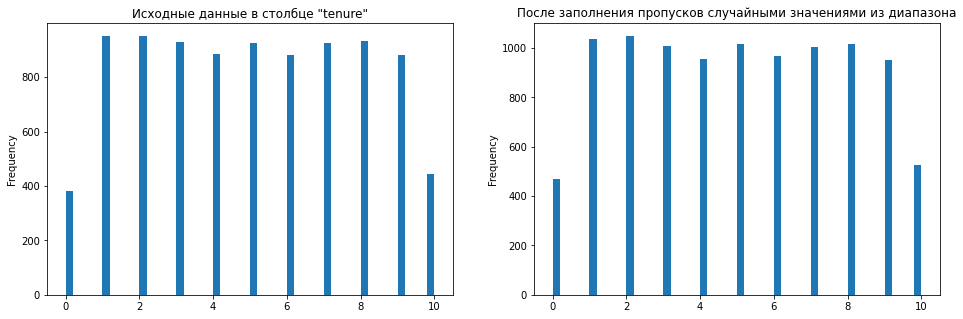

Строки с пропусками данных в столбце "tenure" составляют 0.0 %.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  int64  
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [ ]:
# исходное распределение значений в столбце "tenure"
data['tenure'].plot(kind='hist', ax=plt.subplot(1, 2, 1), figsize=(16, 5), bins=50, 
                    title='Исходные данные в столбце "tenure"')

# заполнение пропусков случайной величиной из диапазона сначений столбца (от 0 до 10)
random.seed(RST)
data['tenure'] = data['tenure'].map(lambda x: x if not np.isnan(x) else random.randint(0, 10))
# альтернатива рандомного заполнения, но каждый запуск по-разному генерит случайные числа
# data['tenure'] = data['tenure'].map(lambda x: x if not np.isnan(x) else np.random.choice(range(0, 10)))

# распределение значений в столбце "tenure" после заполнения пропусков
data['tenure'].plot(kind='hist', bins=50, ax=plt.subplot(1, 2, 2), 
                    title='После заполнения пропусков случайными значениями из диапазона')
plt.show()
print('Строки с пропусками данных в столбце "tenure" составляют', 
      100 * data['tenure'].isna().sum() / len(data['tenure']), '%.\n')

# меняем тип данных столбца "Tenure" на целочисленный
data['tenure'] = data['tenure'].astype('int64')
# выводим результат
data.info()

Статистическая информация:


,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00,10000,10000,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.53,NaN,NaN,38.92,4.99,76485.89,1.53,0.71,0.52,100090.24,0.20
std,96.65,NaN,NaN,10.49,2.92,62397.41,0.58,0.46,0.50,57510.49,0.40
min,350.00,NaN,NaN,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00
25%,584.00,NaN,NaN,32.00,2.00,0.00,1.00,0.00,0.00,51002.11,0.00
50%,652.00,NaN,NaN,37.00,5.00,97198.54,1.00,1.00,1.00,100193.91,0.00
75%,718.00,NaN,NaN,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,0.00


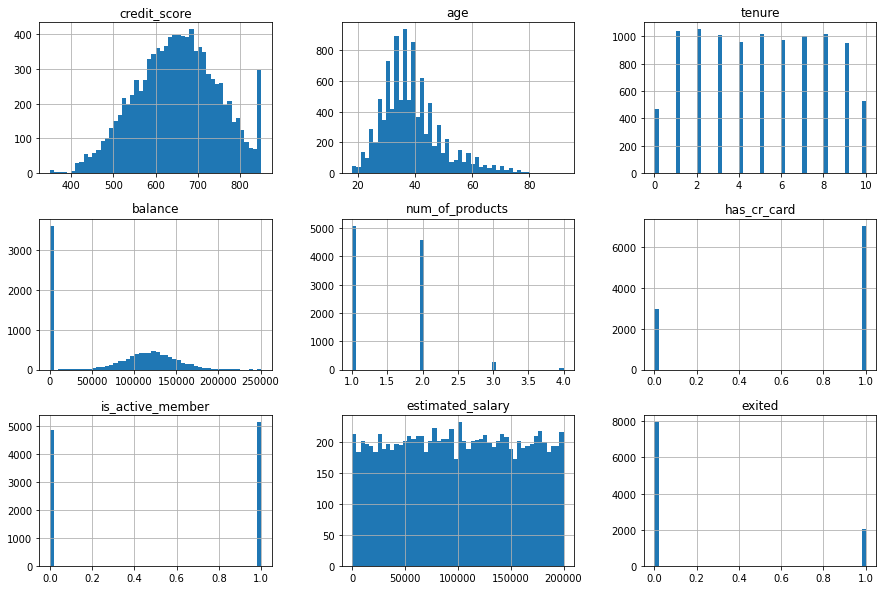

In [ ]:
print('Статистическая информация:')
display(data.describe(include='all'))
data.hist(figsize=(15, 10), bins=50)
plt.show()

### 1.1. <a id='toc1_1_'></a>[Вывод по разделу 1](#toc0_)

Данные успешно загружены. Выполнена небольшая предобработка данных с целью подготовки к дальнейшему исследованию. Размер выборки в 9 тысяч строк достаточен для проведения исследования. Пропуски в данных удалены. Дубликатов нет. Типы данных соответствуют содержимому. Названия столбцов унифицированы. Аномальных значений не наблюдается.

На гистограмме `credit_score` (кредитный рейтинг) можно отметить всплеск на уровне максимального значения кредитного рейтинга (850). Вероятно, это следствие действия внутренней политики банка по присвоению высшего кредитного рейтинга, что является достоверным и приемлемым для исследования.  
На гистограмме `balance` (баланс на счёте) есть сильный выброс на нулевом значении. Это фактические данные банка, у клиентов действительно отсутствуют деньги на открытых счетах. Принимаем эти данные для исследования как есть.  
На гистограмме целевого признака `exited` (факт ухода клиента) видим, что существует дисбаланс классов. Положительных исходов примерно в 3,5 раза меньше, чем отрицательных.

## 2. <a id='toc2_'></a>[Исследование задачи](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Исследование баланса классов](#toc0_)

Целевой признак - факт ухода клиента находится в столбце `exited`. Исследуем его.

,%,описание
класс,,
0,79.63,клиент остался
1,20.37,клиент ушел


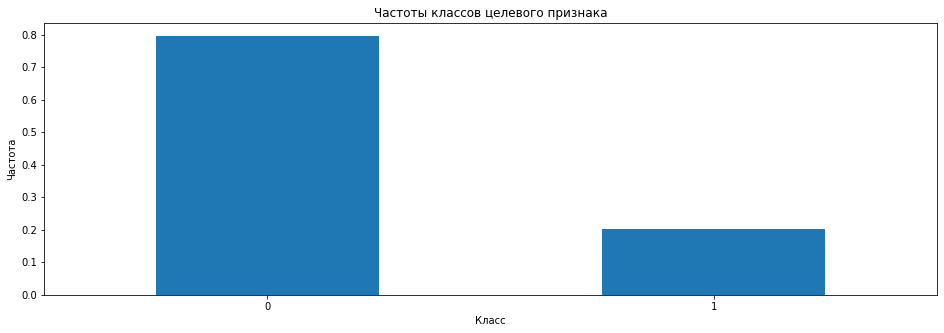

In [ ]:
class_frequency = data['exited'].value_counts(normalize=True)
display(pd.concat([class_frequency.rename('%') * 100, pd.Series(['клиент остался', 'клиент ушел'], name='описание')], axis=1)
      .rename_axis(index='класс'))
class_frequency.plot(kind='bar', figsize=(16, 5))
plt.title('Частоты классов целевого признака')
plt.xlabel('Класс')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

Видим, что баланса классов целевого признака нет. Соотношение классов 4:1 в пользу класса 0 (клиент остался).

### 2.2. <a id='toc2_2_'></a>[Формирование выборок](#toc0_)

Разделим данные на обучающую, валидационную и тестовую выборки в соотношении 60%, 20% и 20% соответственно.  
Целевая переменная - факт ухода клиента (`exited`).

In [ ]:
# разделим исходные данные на параметры (features) и целевую переменную (target)
features = data.drop(['exited'], axis=1)
target = data['exited']

# разделим исходные данные на обучающую, валидационную и тестовую выборки
features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=.4, random_state=RST, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=.5, random_state=RST, stratify=target_valid_test)

# проверим количество строк в сформированных выборках и распределение значений целевой переменной
print(f'''
Обучающая выборка: 
    - параметры (строки, столбцы): {features_train.shape}
    - целевая переменная (строки): {target_train.shape}
        -- количество значений в классах: {np.bincount(target_train)}
        -- соотношение классов: {np.bincount(target_train)[0] / np.bincount(target_train)[1]}''')
print(f'''
Валидационная выборка: 
    - параметры (строки, столбцы): {features_valid.shape}
    - целевая переменная (строки): {target_valid.shape}
        -- количество значений в классах: {np.bincount(target_valid)}
        -- соотношение классов: {np.bincount(target_valid)[0] / np.bincount(target_valid)[1]}''')
print(f'''
Тестовая выборка: 
    - параметры (строки, столбцы): {features_test.shape}
    - целевая переменная (строки): {target_test.shape}
        -- количество значений в классах: {np.bincount(target_test)}
        -- соотношение классов: {np.bincount(target_test)[0] / np.bincount(target_test)[1]}''')

# сделаем копию выборок для работы на этапе балансировки классов
features_train_balans = features_train.copy()
target_train_balans = target_train.copy()
features_valid_balans = features_valid.copy()
target_valid_balans = target_valid.copy()
features_test_balans = features_test.copy()
target_test_balans = target_test.copy()


Обучающая выборка: 
    - параметры (строки, столбцы): (6000, 10)
    - целевая переменная (строки): (6000,)
        -- количество значений в классах: [4778 1222]
        -- соотношение классов: 3.909983633387889

Валидационная выборка: 
    - параметры (строки, столбцы): (2000, 10)
    - целевая переменная (строки): (2000,)
        -- количество значений в классах: [1592  408]
        -- соотношение классов: 3.9019607843137254

Тестовая выборка: 
    - параметры (строки, столбцы): (2000, 10)
    - целевая переменная (строки): (2000,)
        -- количество значений в классах: [1593  407]
        -- соотношение классов: 3.914004914004914


### 2.3. <a id='toc2_3_'></a>[Подготовка признаков](#toc0_)

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 2837 to 700
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      6000 non-null   int64  
 1   geography         6000 non-null   object 
 2   gender            6000 non-null   object 
 3   age               6000 non-null   int64  
 4   tenure            6000 non-null   int64  
 5   balance           6000 non-null   float64
 6   num_of_products   6000 non-null   int64  
 7   has_cr_card       6000 non-null   int64  
 8   is_active_member  6000 non-null   int64  
 9   estimated_salary  6000 non-null   float64
dtypes: float64(2), int64(6), object(2)
memory usage: 515.6+ KB


В выборках есть признаки двух типов:
1. Категориальные:
- `geography` (страна проживания);
- `gender` (пол);  
следующие признаки, не смотря на тип, также являются категориальными бинарными:  
- `has_cr_card` (наличие кредитной карты);
- `is_active_member` (активность клиента).  
Для категориальных признаков будем использовать технику прямого кодирования `One-Hot Encoding`. 
    
2. Численные:
- `credit_score` (кредитный рейтинг);
- `age` (возраст);
- `tenure` (сколько лет человек является клиентом банка);
- `balance` (баланс на счёте);
- `num_of_products` (количество продуктов банка, используемых клиентом);
- `estimated_salary` (предполагаемая зарплата).  
Для численных признаков будем использовать стандартизацию данных `StandardScale`.

In [ ]:
# сформируем список категориальных признаков
# признаки 'has_cr_card' и 'is_active_member' уже имеют нужный формат и не требуют обработки
list_category = features_train.select_dtypes(include='object').columns.to_list()
#list_category.extend(['has_cr_card', 'is_active_member'])
print(f'''
Список категориальных признаков:
{list_category}''')

# сформируем список численных признаков
list_numeral = features_train.select_dtypes(exclude='object').columns.to_list()
list_numeral.remove('has_cr_card')
list_numeral.remove('is_active_member')
print(f'''
Список численных признаков:
{list_numeral}''')


Список категориальных признаков:
['geography', 'gender']

Список численных признаков:
['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']


Подготовим признаки в обучающей выборке.

In [ ]:
# отключение предупреждения 'SettingWithCopy'
pd.options.mode.chained_assignment = None

# кодирование категориальных признаков
encoder = OneHotEncoder(drop='first', sparse=False)
features_train[encoder.get_feature_names()] = encoder.fit_transform(features_train[list_category])
features_train = features_train.drop(list_category, axis=1)

# кодирование численных признаков
scaler = StandardScaler()
features_train[list_numeral] = scaler.fit_transform(features_train[list_numeral])

# вывод результата
display(features_train.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,x0_Germany,x0_Spain,x1_Male
2837,-1.04,0.95,0.34,0.77,-0.91,0,1,-0.12,1.00,0.00,0.00
9925,0.45,-0.10,-1.72,1.91,-0.91,1,1,-0.26,0.00,0.00,0.00
8746,0.10,-0.48,1.03,0.48,0.82,0,1,1.42,0.00,0.00,1.00
660,-0.18,0.19,-1.72,0.09,-0.91,1,1,-1.16,1.00,0.00,0.00
3610,-0.72,1.62,-1.37,0.88,-0.91,1,0,0.11,0.00,0.00,0.00


Подготовим признаки в валидационной выборке обученными на обучающей выборке энкодером (`OneHotEncoder()`) и скалером (`StandardScaler()`).

In [ ]:
# кодирование категориальных признаков
features_valid[encoder.get_feature_names()] = encoder.transform(features_valid[list_category])
features_valid = features_valid.drop(list_category, axis=1)

# кодирование численных признаков
features_valid[list_numeral] = scaler.transform(features_valid[list_numeral])

# вывод результата
display(features_valid.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,x0_Germany,x0_Spain,x1_Male
6612,-1.52,2.38,-0.69,1.01,-0.91,0,1,0.01,0.00,0.00,0.00
519,0.59,1.81,0.34,0.21,-0.91,0,1,0.45,0.00,0.00,1.00
1609,-0.32,-0.38,1.03,0.89,-0.91,1,0,-0.60,0.00,0.00,0.00
3475,1.23,-0.76,-0.34,-0.24,0.82,1,1,-1.62,0.00,0.00,1.00
2707,-0.13,-0.10,-0.69,0.45,-0.91,0,0,0.34,0.00,0.00,0.00


### 2.4. <a id='toc2_4_'></a>[Исследование моделей на несбалансированной выборке](#toc0_)

Исследование проведем на трех типах моделей:
- "дерево решений" (DecisionTreeClassifier);
- "случайный лес" (RandomForestClassifier);
- "логистическая регрессия" (LogisticRegression)

путем регулирования гиперпараметров моделей:
- глубина дерева от 1 до 10 для моделей "дерево решений";
- количество деревьев от 10 до 100 с шагом 10 и глубина дерева от 1 до 10 для моделей "случайный лес";
- количество итераций от 100 до 1000 с шагом 10 для моделей "логистическая регрессия".

Критерием выбора лучшей модели будет наибольшее значение F1-меры.  
Для лучших подобранных моделей кроме F1-меры будем вычислять значение AUC-ROC.

In [ ]:
mod_dtc_u, f1_dtc_u, ar_dtc_u = model_dtc(features_train, target_train, features_valid, target_valid)
mod_rfc_u, f1_rfc_u, ar_rfc_u = model_rfc(features_train, target_train, features_valid, target_valid)
mod_lr_u, f1_lr_u, ar_lr_u = model_lr(features_train, target_train, features_valid, target_valid)


    Модель "дерево решений".
    Наибольшее значение F1-меры 0.5880640465793304 при глубине дерева 7.
    Значение AUC-ROC составляет 0.8233331177948566.

    Модель "случайный лес".
    Наибольшее значение F1-меры 0.60882800608828 при 20 деревьях и глубине дерева 9.
    Значение AUC-ROC составляет 0.8680103951128191.

    Модель "логистическая регрессия".
    Наибольшее значение F1-меры 0.30458715596330277 при количестве итераций 100.
    Значение AUC-ROC составляет 0.7875514213222977.


В результате подбора гиперпараметров для трех типов моделей, наибольшее значение F1-меры 0.60882800608828 удалось достичь на модели "случайный лес" из 20 деревьев с глубиной дерева 9.  
При этом AUC-ROC также имеет максимальне значение и составляет 0.8680103951128191.

### 2.5. <a id='toc2_5_'></a>[Вывод по разделу 2](#toc0_)

- Изучение баланса классов целевого признака показало наличие дисбаланса в соотношении 1:4.
- Из исходных данных сформированы обучающая, валидационная и тестовая выборки в соотношении 60%, 20% и 20% соответственно.
- Во всех выборках проведена подготовка признаков:
    - категориальных - с помощью техники прямого кодирования One-Hot Encoding;
    - численных - с помощью стандартизации данных методом StandardScale.
- Проведено исследование трех типов моделей: "дерево решений", "случайный лес" и "логистическая регрессия" путем подбора гиперпараметров. Наибольшее значение F1-меры удалось получить на модели "случайный лес".
- Значение F1-меры для лучшей из моделей ("случайный лес") на валидационной выборке составило 0.60882800608828, значение AUC-ROC составило 0.8680103951128191.

## 3. <a id='toc3_'></a>[Улучшение качества модели с учетом дисбаланса классов](#toc0_)

Для улучшения качества моделей уменьшим влияние дисбаланса классов, применяя следующие техники:
1. Взвешивание классов.
2. Изменение размеров - увеличение/уменьшение выборки (upsampling/downsampling).

### 3.1. <a id='toc3_1_'></a>[Применение техники взвешивания классов](#toc0_)

Используем параметр `class_weight='balanced'` для балансировки классов при создании моделей и выберем лучшие модели каждого типа, подбирая гиперпараметры и оценивая F1-меру.

In [ ]:
mod_dtc_b1, f1_dtc_b1, ar_dtc_b1 = model_dtc(features_train, target_train, features_valid, target_valid, 'balanced')
mod_rfc_b1, f1_rfc_b1, ar_rfc_b1 = model_rfc(features_train, target_train, features_valid, target_valid, 'balanced')
mod_lr_b1, f1_lr_b1, ar_lr_b1 = model_lr(features_train, target_train, features_valid, target_valid, 'balanced')


    Модель "дерево решений".
    Наибольшее значение F1-меры 0.5764596848934197 при глубине дерева 6.
    Значение AUC-ROC составляет 0.8253437838703321.

    Модель "случайный лес".
    Наибольшее значение F1-меры 0.653061224489796 при 100 деревьях и глубине дерева 9.
    Значение AUC-ROC составляет 0.8726845009360529.

    Модель "логистическая регрессия".
    Наибольшее значение F1-меры 0.5280701754385966 при количестве итераций 100.
    Значение AUC-ROC составляет 0.793772785496108.


Применение техники взвешивания классов дало прирост параметров F1-меры и AUC-ROC для всех типов моделей. Наиболее значимые улучшения получила модель "логистическая регрессия".

Лучшие значения F1-меры и AUC-ROC показала модель "случайный лес":
- F1-мера: 0.6530089628681178;
- AUC-ROC: 0.876452256457733.

### 3.2. <a id='toc3_2_'></a>[Применение техники изменения размера выборки (upsampling)](#toc0_)

Из двух техник, связанных с изменением размера выборки, выберем технику увеличения выборки (upsampling), чтобы не сокращать объем имеющихся данных.

Посмотрим текущий баланс классов целевого параметра в обучающей выборке.

In [ ]:
display(target_train_balans.value_counts(normalize=True))

0   0.80
1   0.20
Name: exited, dtype: float64

Соотношение 4:1 в пользу отрицательных объектов. Применим upsampling к обучающей выборке, увеличивая количество положительных объектов в 4 раза.

In [ ]:
# делим обучающие выборки на отрицательные и положительные объекты
features_zeros = features_train_balans[target_train_balans == 0]
features_ones = features_train_balans[target_train_balans == 1]
target_zeros = target_train_balans[target_train_balans == 0]
target_ones = target_train_balans[target_train_balans == 1]

# увеличиваем количество положительных объектов в 4 раза путем копирования
features_train_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_train_upsampled = pd.concat([target_zeros] + [target_ones] * 4)

# перемешиваем
features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=RST)

# вывод результатов
print(f'''
До применения upsampling:
    - параметры: {features_train_balans.shape}
    - целевой признак: {target_train_balans.shape}
    - баланс классов: 
{target_train_balans.value_counts(normalize=True, sort=False)}
      
После применения upsampling:
    - параметры: {features_train_upsampled.shape}
    - целевой признак: {target_train_upsampled.shape}
    - баланс классов:
{target_train_upsampled.value_counts(normalize=True, sort=False)}''')


До применения upsampling:
    - параметры: (6000, 10)
    - целевой признак: (6000,)
    - баланс классов: 
0   0.80
1   0.20
Name: exited, dtype: float64
      
После применения upsampling:
    - параметры: (9666, 10)
    - целевой признак: (9666,)
    - баланс классов:
0   0.49
1   0.51
Name: exited, dtype: float64


Выполним предобработку категориальных и численных признаков сбалансированной обучающей выборки.

In [ ]:
# кодирование категориальных признаков обучающей выборки
encoder_balans = OneHotEncoder(drop='first', sparse=False)
features_train_upsampled[encoder_balans.get_feature_names()] = encoder_balans.fit_transform(
    features_train_upsampled[list_category])
features_train_upsampled = features_train_upsampled.drop(list_category, axis=1)

# кодирование численных признаков обучающей выборки
scaler_balans = StandardScaler()
features_train_upsampled[list_numeral] = scaler_balans.fit_transform(features_train_upsampled[list_numeral])

# вывод результата
display(features_train_upsampled.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,x0_Germany,x0_Spain,x1_Male
6785,-0.28,-0.02,0.01,0.37,-0.76,1,1,-0.09,0.00,1.00,1.00
8042,-0.43,-0.40,0.35,0.00,-0.76,0,0,1.24,0.00,0.00,1.00
2962,-1.00,-0.30,1.38,0.95,2.27,1,1,1.23,0.00,0.00,1.00
2492,-1.31,-0.96,-0.68,0.44,-0.76,1,1,1.44,1.00,0.00,0.00
2414,-0.94,1.01,1.38,-1.34,-0.76,1,0,1.29,0.00,0.00,0.00


Выполним предобработку категориальных и численных признаков валидационной выборки обученными на сбалансированной обучающей выборке энкодером (`OneHotEncoder()`) и скалером (`StandardScaler()`).

In [ ]:
# кодирование категориальных признаков валидационной выборки
features_valid_balans[encoder_balans.get_feature_names()] = encoder_balans.transform(features_valid_balans[list_category])
features_valid_balans = features_valid_balans.drop(list_category, axis=1)

# кодирование численных признаков валидационной выборки
features_valid_balans[list_numeral] = scaler_balans.transform(features_valid_balans[list_numeral])

# вывод результата
display(features_valid_balans.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,x0_Germany,x0_Spain,x1_Male
6612,-1.49,2.13,-0.68,0.94,-0.76,0,1,0.00,0.00,0.00,0.00
519,0.59,1.57,0.35,0.12,-0.76,0,1,0.44,0.00,0.00,1.00
1609,-0.30,-0.58,1.04,0.82,-0.76,1,0,-0.61,0.00,0.00,0.00
3475,1.23,-0.96,-0.33,-0.34,0.76,1,1,-1.63,0.00,0.00,1.00
2707,-0.12,-0.30,-0.68,0.36,-0.76,0,0,0.33,0.00,0.00,0.00


Найдем лучшие модели каждого исследуемого типа, подбирая гиперпараметры и оценивая F1-меру.

In [ ]:
mod_dtc_b2, f1_dtc_b2, ar_dtc_b2 = model_dtc(features_train_upsampled, target_train_upsampled, 
                                             features_valid_balans, target_valid_balans)
mod_rfc_b2, f1_rfc_b2, ar_rfc_b2 = model_rfc(features_train_upsampled, target_train_upsampled, 
                                             features_valid_balans, target_valid_balans)
mod_lr_b2, f1_lr_b2, ar_lr_b2 = model_lr(features_train_upsampled, target_train_upsampled, 
                                         features_valid_balans, target_valid_balans)


    Модель "дерево решений".
    Наибольшее значение F1-меры 0.5764596848934197 при глубине дерева 6.
    Значение AUC-ROC составляет 0.8253591794758104.

    Модель "случайный лес".
    Наибольшее значение F1-меры 0.6545454545454547 при 90 деревьях и глубине дерева 9.
    Значение AUC-ROC составляет 0.8734281086806582.

    Модель "логистическая регрессия".
    Наибольшее значение F1-меры 0.5246753246753246 при количестве итераций 100.
    Значение AUC-ROC составляет 0.7938405261602128.


### 3.3. <a id='toc3_3_'></a>[Одновременное применение нескольких техник](#toc0_)

Применим последовательно обе рассматриваемые техники уменьшения дисбаланса классов upsampling и взвешивание классов.

In [ ]:
mod_dtc_b3, f1_dtc_b3, ar_dtc_b3 = model_dtc(features_train_upsampled, target_train_upsampled, 
                                             features_valid_balans, target_valid_balans, 'balanced')
mod_rfc_b3, f1_rfc_b3, ar_rfc_b3 = model_rfc(features_train_upsampled, target_train_upsampled, 
                                             features_valid_balans, target_valid_balans, 'balanced')
mod_lr_b3, f1_lr_b3, ar_lr_b3 = model_lr(features_train_upsampled, target_train_upsampled, 
                                         features_valid_balans, target_valid_balans, 'balanced')


    Модель "дерево решений".
    Наибольшее значение F1-меры 0.5764596848934197 при глубине дерева 6.
    Значение AUC-ROC составляет 0.8253437838703321.

    Модель "случайный лес".
    Наибольшее значение F1-меры 0.6511111111111112 при 90 деревьях и глубине дерева 10.
    Значение AUC-ROC составляет 0.8700410754754164.

    Модель "логистическая регрессия".
    Наибольшее значение F1-меры 0.5280701754385966 при количестве итераций 100.
    Значение AUC-ROC составляет 0.7937589294511775.


### 3.4. <a id='toc3_4_'></a>[Вывод по разделу 3](#toc0_)

Сведем результаты всех исследований в общую таблицу.

In [ ]:
models_param = pd.DataFrame(data=[
        [f1_dtc_u, ar_dtc_u, f1_rfc_u, ar_rfc_u, f1_lr_u, ar_lr_u],
        [f1_dtc_b1, ar_dtc_b1, f1_rfc_b1, ar_rfc_b1, f1_lr_b1, ar_lr_b1],
        [f1_dtc_b2, ar_dtc_b2, f1_rfc_b2, ar_rfc_b2, f1_lr_b2, ar_lr_b2],
        [f1_dtc_b3, ar_dtc_b3, f1_rfc_b3, ar_rfc_b3, f1_lr_b3, ar_lr_b3]],
         index=[['выборка с дисбалансом классов', 'сбалансированные выборки:', 'сбалансированные выборки:',
                 'сбалансированные выборки:'], ['','взвешивание классов','upsampling','две техники']],
         columns=[['дерево решений', 'дерево решений', 'случайный лес','случайный лес', 'логистическая регрессия', 
                   'логистическая регрессия'],['F1-мера', 'AUC-ROC', 'F1-мера', 'AUC-ROC', 'F1-мера', 'AUC-ROC']])
display(models_param)

дерево решений          \
                                                         F1-мера AUC-ROC   
выборка с дисбалансом классов                               0.59    0.82   
сбалансированные выборки:     взвешивание классов           0.58    0.83   
                              upsampling                    0.58    0.83   
                              две техники                   0.58    0.83   

                                                  случайный лес          \
                                                        F1-мера AUC-ROC   
выборка с дисбалансом классов                              0.61    0.87   
сбалансированные выборки:     взвешивание классов          0.65    0.87   
                              upsampling                   0.65    0.87   
                              две техники                  0.65    0.87   

                                                  логистическая регрессия  \
                                                                  F1-мера   
выборка с дисбалансом классов                                        0.30   
сбалансированные выборки:     взвешивание классов                    0.53   
                              upsampling                             0.52   
                              две техники                            0.53   

                                                           
                                                  AUC-ROC  
выборка с дисбалансом классов                        0.79  
сбалансированные выборки:     взвешивание классов    0.79  
                              upsampling             0.79  
                              две техники            0.79

Сравнив результаты, можно сделать следующие выводы:
- На выборке с дисбалансом классов все модели показывают худшие значения F1-мера.
- Параметр AUC-ROC, в отличии от F1-меры, не зависит от наличия или отсутствия дисбаланса классов. Зависит от типа модели.
- Рассмотренные техники борьбы с дисбалансом классов равноэффективны, так как позволяют на каждой из моделей достичь своих примерно одинаковых показателей.
- Применение последовательно двух техник балансировки классов не дает дальнейшего улучшения, достаточно применения одной из техник.
- Лучшие разультаты как на выборке с дисбалансом, так и на сбалансированной выборке показывает модель "случайный лес". Худшие показатели у модели "логистическая регрессия".

## 4. <a id='toc4_'></a>[Финальное тестирование](#toc0_)

В ходе исследования лучшие результаты показала модель "случайный лес" на выборке, сбалансированной методом взвешивания классов. Протестируем этот лучший результат с помощью тестовой выборки.

In [ ]:
# кодирование категориальных признаков в тестовой выборке настроенным энкодером
features_test_balans[encoder_balans.get_feature_names()] = encoder_balans.transform(features_test_balans[list_category])
features_test_balans = features_test_balans.drop(list_category, axis=1)

# кодирование численных признаков в тестовой выборке настроенным скалером
features_test_balans[list_numeral] = scaler_balans.transform(features_test_balans[list_numeral])

# просмотр результата
display(features_test_balans.head())

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,x0_Germany,x0_Spain,x1_Male
657,-0.48,1.19,-1.36,0.80,0.76,1,1,1.72,1.00,0.00,0.00
2083,-1.16,-1.61,-1.36,-1.34,-0.76,1,1,1.19,0.00,0.00,1.00
3234,-1.24,0.54,-1.36,-1.34,-0.76,1,0,-1.39,0.00,0.00,1.00
1551,0.83,1.01,0.69,-1.34,0.76,0,1,0.37,0.00,1.00,0.00
2344,0.67,0.73,-0.33,0.18,-0.76,1,0,-1.62,1.00,0.00,0.00


In [ ]:
# получим предсказания лучшей обученной модели типа "случайный лес" на тестовой выборке
predictions = mod_rfc_b1.predict(features_test_balans)

# определяем F1-меру на тестовой выборке
f1_rfc_test = f1_score(target_test_balans, predictions)

# определяем AUC-ROC на тестовой выборке
probabilities_test = mod_rfc_b1.predict_proba(features_test_balans)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test = roc_auc_score(target_test_balans, probabilities_one_test)

# вывод результатов
print(f'Значение F1-меры на тестовой выборке: {f1_rfc_test}.')
print(f'Значение AUC-ROC на тестовой выборке: {auc_roc_test}.')

Значение F1-меры на тестовой выборке: 0.6104218362282878.
Значение AUC-ROC на тестовой выборке: 0.8541345659989728.


Отобразим важность факторов (признаков) для лучшей модели.

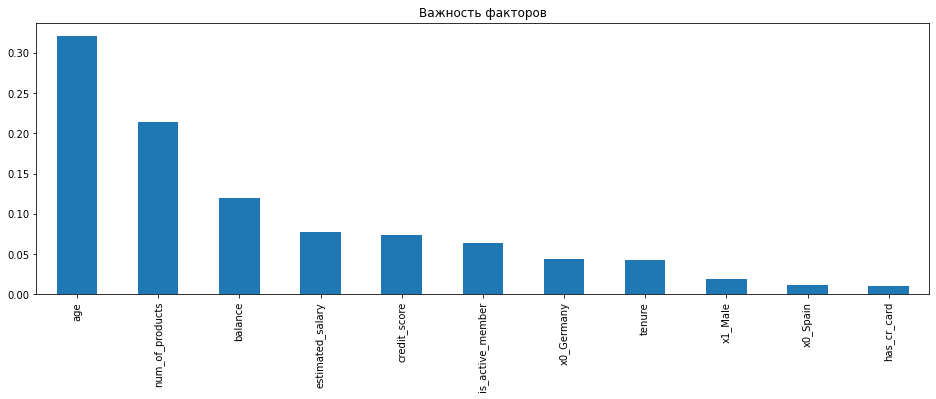

In [ ]:
pd.Series(mod_rfc_b1.feature_importances_, features_test_balans.columns).sort_values(ascending=False).plot(
    kind='bar', figsize=(16,5), title='Важность факторов')
plt.show()

### 4.1. <a id='toc4_1_'></a>[Вывод по разделу 4](#toc0_)

Значение F1-меры выше порогового значения 0,59 на тестовой выборке достигнуто.

Наибольшее влияние на прогноз оказывают признаки возраста клиента, количества у него продуктов банка и баланс на счете.

## 5. <a id='toc5_'></a>[Общий вывод](#toc0_)

Данные загружены, выполнена небольшая предобработка с целью подготовки к дальнейшему исследованию. Размер выборки в 9 тысяч строк достаточен для проведения исследования.  
Изучение баланса классов целевого признака показало наличие дисбаланса в соотношении 1:4.  
Из исходных данных сформированы обучающая, валидационная и тестовая выборки в соотношении 60%, 20% и 20% соответственно. Исследование проводилось на тестовой и валидационной выборках, финальное тестирование на тестовой выборке.  

Для исследования были выбраны три типа моделей: "дерево решений" (DecisionTreeClassifier), "случайный лес" (RandomForestClassifier) и "логистическая регрессия" (LogisticRegression). Выбор лучшей модели осуществлялся подбором гиперпараметров с контролем значения F1-меры.

Перед передачей данных в модели выполнялась подготовка признаков:
- категориальных (техника прямого кодирования One-Hot Encoding);
- численных (стандартизация данных методом StandardScale).

Для улучшения качества моделей применялись следующие техники уменьшения влияния дисбаланса классов:
- взвешивание классов;
- увеличение выборки (upsampling);
- последовательное применение двух техник.


По итогам исследования можно сделать следующие выводы:
- На выборке с дисбалансом классов все модели показывают значения F1-меры хуже, чем на сбалансированной выборке. Наибольшее значение F1-меры удалось получить на модели "случайный лес".
- Рассмотренные техники борьбы с дисбалансом классов равноэффективны, так как позволяют на каждой из моделей достичь своих примерно одинаковых показателей. Применение последовательно двух техник балансировки классов не дает дальнейшего улучшения, достаточно применения одной из техник. Лучшие разультаты на сбалансированной выборке показала модель "случайный лес", худшие - модель "логистическая регрессия".
- Отдельно можно отметить, что параметр AUC-ROC, в отличии от F1-меры, не зависит от наличия или отсутствия дисбаланса классов, но зависит от типа модели.
- На тестовой выборке значение F1-меры выше заданного 0,59 получено на модели "случайный лес" для сбалансированной выборки.
- Наибольшее влияние на прогноз оказывают признаки возраста клиента, количества у него продуктов банка и баланс на счете.